# Import packages

In [1]:
%pip install -q pandas matplotlib numpy scikit-learn ace_tools panelsplit shap upgrade jupyter ipywidgets
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


Looking in indexes: https://download.pytorch.org/whl/cu118Note: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

In [1]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA Available: False


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [4]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import random

import zipfile
import os

import numpy as np
import pandas as pd

from panelsplit.cross_validation import PanelSplit

import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# Import dataset

In [5]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

In [6]:
# y 
y = final_df['pc_loss']
y = np.log1p(final_df['pc_loss'])
y = y.to_numpy()

# Normalize output
scaler = StandardScaler()

# X final
X1 = final_df.drop(columns=['year', 'codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'pc_loss', 'f_loss', 'areaoficialhm2', 'gdp']) # GDP, area already out since the were already considered
X1 = X1.drop(columns=['CV-01-15','CV-03-64', 'CV-03-26b', 'CV-01-11', 'CV-01-1', 'PCC-02-0', 'PCC-02-3', 'EIS-00-0', 'PCC-00-0', 'CTI-00-0', 'C-02-8t', 'ICM-00-0',
                      'EIS-03-4', 'CTI-01-3', 'SEG-00-0', 'SEG-01-6', 'SOS-00-0', 'SOS-02-0', 'SOS-02-2', 'SOS-01-6', 'GPI-00-0', 'GPI-02-4', 'GPI-02-5', 'P-01-34-1',
                      'P-01-46', 'P-01-25', 'CV-02-12e', 'CV-03-51', 'total_ac']) 


# Keep feature names
original_feature_names = list(X1.columns) 

# Normalize features
X1 = scaler.fit_transform(X1)

# Lasso

In [7]:
class LassoRegression(nn.Module):
    def __init__(self, input_dim, l1_lambda=0.01):
        super(LassoRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.l1_lambda = l1_lambda  # Regularization strength

    def forward(self, x):
        return self.linear(x)

    def l1_regularization_loss(self):
        return self.l1_lambda * torch.norm(self.linear.weight, p=1)  # L1 Regularization (Lasso)


In [12]:
# Set seed for reproducibility
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # If using GPU

# Define TimeSeriesSplit (e.g., 5 splits)
panel_split = PanelSplit(periods=final_df.year, n_splits=5)

# Hyperparameters
lambda_values = [0.00001, 0.0001, 0.001, 0.01, 0.05, 1]  # Different L1 values
epochs = 1000

# Adjusted R² function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

# Dictionary to store results across all lambda values
results = {}

# Perform TimeSeriesSplit Cross-Validation
for l1_lambda in lambda_values:  # Move lambda loop to the outermost level
    fold_results = []  # Store results for each fold

    for train_idx, test_idx in panel_split.split(X1):
        # Create interaction terms (degree=2 means pairwise interactions)
        # poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
        # X_interactions = poly.fit_transform(X1)

        # Split dataset into train & test per fold
        X_train1, X_test1 = X1[train_idx], X1[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Convert to PyTorch tensors
        X_train_tensor1 = torch.tensor(X_train1, dtype=torch.float32).to(device)
        X_test_tensor1 = torch.tensor(X_test1, dtype=torch.float32).to(device)
        y_tensor_train = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
        y_tensor_test = torch.tensor(y_test, dtype=torch.float32).to(device).unsqueeze(1)

        # Train and evaluate for each lambda value
        model = LassoRegression(X_train_tensor1.shape[1], l1_lambda=l1_lambda).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        # Training Loop
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_train_tensor1)
            loss = criterion(y_pred, y_tensor_train) + model.l1_regularization_loss()
            loss.backward()
            optimizer.step()

        # Evaluate on train & test sets
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor1)  # Training predictions
            y_test_pred = model(X_test_tensor1)   # Test predictions

        # Convert predictions to NumPy for evaluation
        y_train_pred_numpy = y_train_pred.cpu().numpy().flatten()
        y_test_pred_numpy = y_test_pred.cpu().numpy().flatten()
        y_train_numpy = y_tensor_train.cpu().numpy().flatten()
        y_test_numpy = y_tensor_test.cpu().numpy().flatten()

        # Compute metrics
        mse = mean_squared_error(y_test_numpy, y_test_pred_numpy)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_numpy, y_test_pred_numpy)
        r2_test = r2_score(y_test_numpy, y_test_pred_numpy)  # Test R²
        r2_train = r2_score(y_train_numpy, y_train_pred_numpy)  # Train R²

        # Compute Adjusted R²
        n_train, k = X_train1.shape
        n_test = X_test1.shape[0]

        adj_r2_train = adjusted_r2(r2_train, n_train, k)
        adj_r2_test = adjusted_r2(r2_test, n_test, k)

        # Store results for this fold
        fold_results.append({
            "MSE": mse, "RMSE": rmse, "MAE": mae, "R2_test": r2_test, "R2_train": r2_train,
            "Adj_R2_test": adj_r2_test, "Adj_R2_train": adj_r2_train
        })

    # Compute average performance across all folds for this lambda
    avg_results = {
        metric: np.mean([fold[metric] for fold in fold_results])
        for metric in fold_results[0].keys()
    }

    # Save results correctly associated with lambda
    results[l1_lambda] = avg_results  # Fixed: Now storing results for each lambda properly

# Find the best lambda
best_lambda = min(results, key=lambda x: (results[x]["RMSE"]))  # Minimize MSE, maximize R²
best_metrics = results[best_lambda]  # Get the metrics for the best lambda

# Print optimal hyperparameters and their performance
print(f"🔢 Number of features after Polynomial Features: {X1.shape[1]}")
print(f"✅ Optimal L1 lambda: {best_lambda}")
print(f"📊 Best MSE: {best_metrics['MSE']:.4f}")
print(f"📊 Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 Best MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}, Adjusted R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}, Adjusted R² (Test): {best_metrics['Adj_R2_test']:.4f}")


🔢 Number of features after Polynomial Features: 71
✅ Optimal L1 lambda: 0.001
📊 Best MSE: 0.0087
📊 Best RMSE: 0.0928
📊 Best MAE: 0.0526
📊 R² (Train): 0.1989, Adjusted R² (Train): 0.1931
📊 R² (Test): 0.2850, Adjusted R² (Test): 0.2370


In [13]:
# Ensure Model is on GPU
model = LassoRegression(X_train_tensor1.shape[1], l1_lambda=best_lambda).to(device)

# Define Optimizer with Optimized `lr`
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define Loss Function
criterion = torch.nn.MSELoss()

# Train the Model
epochs = 1000  # Define number of epochs
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(X_train_tensor1)  # Forward pass
    loss = criterion(y_pred, y_tensor_train) + model.l1_regularization_loss()  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

# Define function for SHAP to make predictions
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32).to(device)  # Convert to PyTorch tensor
    return model(X_tensor).detach().cpu().numpy()  # Get predictions


# Create SHAP Explainer
explainer = shap.Explainer(model_predict, X_train1)  # Use the model_predict function for SHAP

# Compute SHAP Values
shap_values_l1 = explainer(X_train1)


PermutationExplainer explainer: 12448it [07:20, 28.25it/s]                           


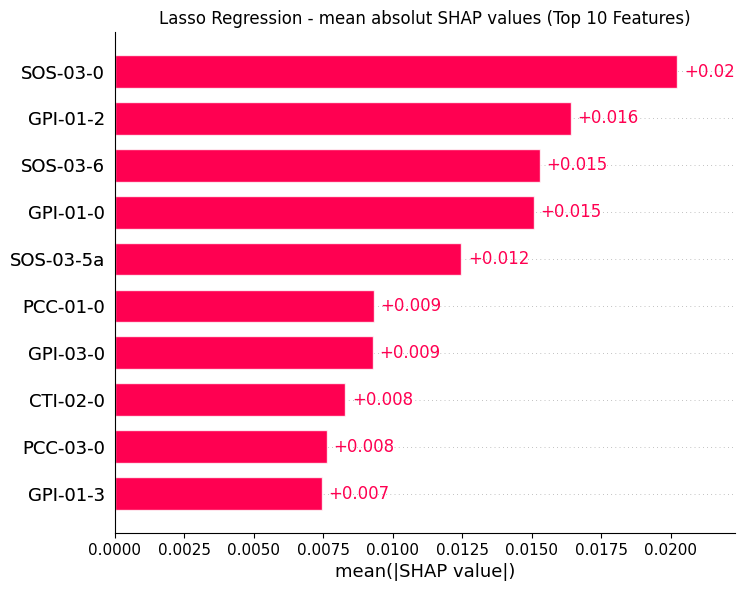

In [11]:
# Compute mean absolute SHAP values for each feature
shap_abs_mean_l1 = np.abs(shap_values_l1.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean_l1)[-10:]

# Filter SHAP values to keep only the top 10 features
shap_values_top10_l1 = shap.Explanation(
    values=shap_values_l1.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values_l1.base_values,  # Keep base values
    data=shap_values_l1.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)

# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10_l1, show=False)
plt.title("Lasso Regression - mean absolut SHAP values (Top 10 Features)")
plt.show()


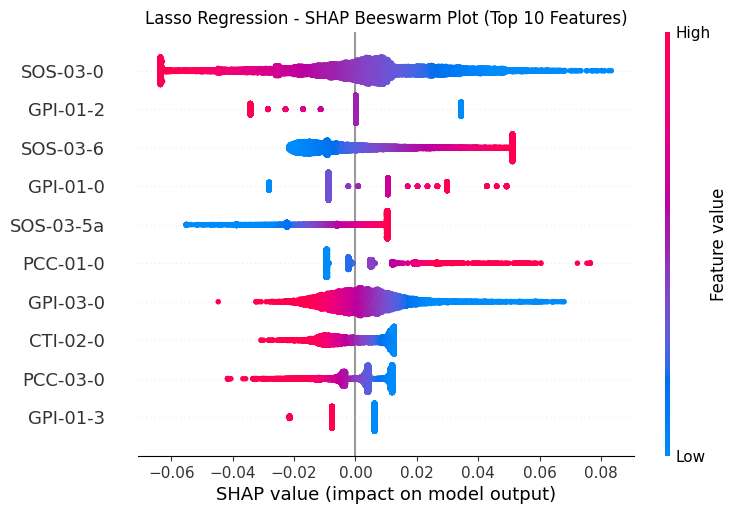

In [12]:
# Beeswarm plot for top 10 features
shap.plots.beeswarm(shap_values_top10_l1, show=False)
plt.title("Lasso Regression - SHAP Beeswarm Plot (Top 10 Features)")
plt.show()

# Ridge

In [13]:
# Define Ridge Regression Model
class RidgeRegression(nn.Module):
    def __init__(self, input_dim, l2_lambda=0.01):
        super(RidgeRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.l2_lambda = l2_lambda  # L2 Regularization Parameter

    def forward(self, x):
        return self.linear(x)

    def l2_regularization_loss(self):
        return self.l2_lambda * torch.sum(self.linear.weight ** 2)  # L2 penalty


In [14]:
# Set seed for reproducibility
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # If using GPU

# Define TimeSeriesSplit (e.g., 5 splits)
panel_split = PanelSplit(periods=final_df.year, n_splits=5)

# Hyperparameters
lambda_values = [0.00001, 0.0001, 0.001, 0.01, 0.05, 1]  # Different L2 values
epochs = 1000

# Adjusted R² function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

# Dictionary to store results across all lambda values
results = {}

# Perform TimeSeriesSplit Cross-Validation
for l2_lambda in lambda_values:  # Move lambda loop to the outermost level
    fold_results = []  # Store results for each fold

    for train_idx, test_idx in panel_split.split(X1):
        # Create interaction terms (degree=2 means pairwise interactions)
        # poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        # X_interactions = poly.fit_transform(X1)

        # Split dataset into train & test per fold
        X_train1, X_test1 = X1[train_idx], X1[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Convert to PyTorch tensors
        X_train_tensor1 = torch.tensor(X_train1, dtype=torch.float32).to(device)
        X_test_tensor1 = torch.tensor(X_test1, dtype=torch.float32).to(device)
        y_tensor_train = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
        y_tensor_test = torch.tensor(y_test, dtype=torch.float32).to(device).unsqueeze(1)  

        # Train and evaluate for each lambda value
        model = RidgeRegression(X_train_tensor1.shape[1], l2_lambda=l2_lambda).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        # Training Loop
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_train_tensor1)
            loss = criterion(y_pred, y_tensor_train) + model.l2_regularization_loss()
            loss.backward()
            optimizer.step()

        # Evaluate on train & test sets
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor1)  # Training predictions
            y_test_pred = model(X_test_tensor1)   # Test predictions

        # Convert predictions to NumPy for evaluation
        y_train_pred_numpy = y_train_pred.cpu().numpy().flatten()
        y_test_pred_numpy = y_test_pred.cpu().numpy().flatten()
        y_train_numpy = y_tensor_train.cpu().numpy().flatten()
        y_test_numpy = y_tensor_test.cpu().numpy().flatten()

        # Compute metrics
        mse = mean_squared_error(y_test_numpy, y_test_pred_numpy)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_numpy, y_test_pred_numpy)
        r2_test = r2_score(y_test_numpy, y_test_pred_numpy)  # Test R²
        r2_train = r2_score(y_train_numpy, y_train_pred_numpy)  # Train R²

        # Compute Adjusted R²
        n_train, k = X_train1.shape
        n_test = X_test1.shape[0]

        adj_r2_train = adjusted_r2(r2_train, n_train, k)
        adj_r2_test = adjusted_r2(r2_test, n_test, k)

        # Store results for this fold
        fold_results.append({
            "MSE": mse, "RMSE": rmse, "MAE": mae, "R2_test": r2_test, "R2_train": r2_train,
            "Adj_R2_test": adj_r2_test, "Adj_R2_train": adj_r2_train
        })

    # Compute average performance across all folds for this lambda
    avg_results = {
        metric: np.mean([fold[metric] for fold in fold_results])
        for metric in fold_results[0].keys()
    }

    # Save results correctly associated with lambda
    results[l2_lambda] = avg_results  # Fixed: Now storing results for each lambda properly

# Find the best lambda
best_lambda = min(results, key=lambda x: (results[x]["RMSE"]))  # Minimize MSE, maximize R²
best_metrics = results[best_lambda]  # Get the metrics for the best lambda

# Print optimal hyperparameters and their performance
print(f"🔢 Number of features after Polynomial Features: {X1.shape[1]}")
print(f"✅ Optimal L1 lambda: {best_lambda}")
print(f"📊 Best MSE: {best_metrics['MSE']:.4f}")
print(f"📊 Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 Best MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}, Adjusted R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}, Adjusted R² (Test): {best_metrics['Adj_R2_test']:.4f}")

🔢 Number of features after Polynomial Features: 71
✅ Optimal L1 lambda: 0.05
📊 Best MSE: 0.0087
📊 Best RMSE: 0.0926
📊 Best MAE: 0.0529
📊 R² (Train): 0.2003, Adjusted R² (Train): 0.1945
📊 R² (Test): 0.2883, Adjusted R² (Test): 0.2405


In [15]:
# Ensure Model is on GPU
model = RidgeRegression(X_train_tensor1.shape[1], l2_lambda=best_lambda).to(device)

# Define Optimizer with Optimized `lr`
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define Loss Function
criterion = torch.nn.MSELoss()

# Train the Model
epochs = 1000  # Define number of epochs
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(X_train_tensor1)  # Forward pass
    loss = criterion(y_pred, y_tensor_train) + model.l2_regularization_loss()  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

# Define function for SHAP to make predictions
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32).to(device)  # Convert to PyTorch tensor
    return model(X_tensor).detach().cpu().numpy()  # Get predictions

# Check if it works
test_pred = model_predict(X_train1)  # Try predicting a few samples

# Create SHAP Explainer
explainer = shap.Explainer(model_predict, X_train1)

# Compute SHAP Values
shap_values_l2 = explainer(X_train1)


PermutationExplainer explainer: 12448it [06:48, 29.83it/s]                           


Text(0.5, 1.0, 'Ridge Regression - mean absolut SHAP values (Top 10 Features)')

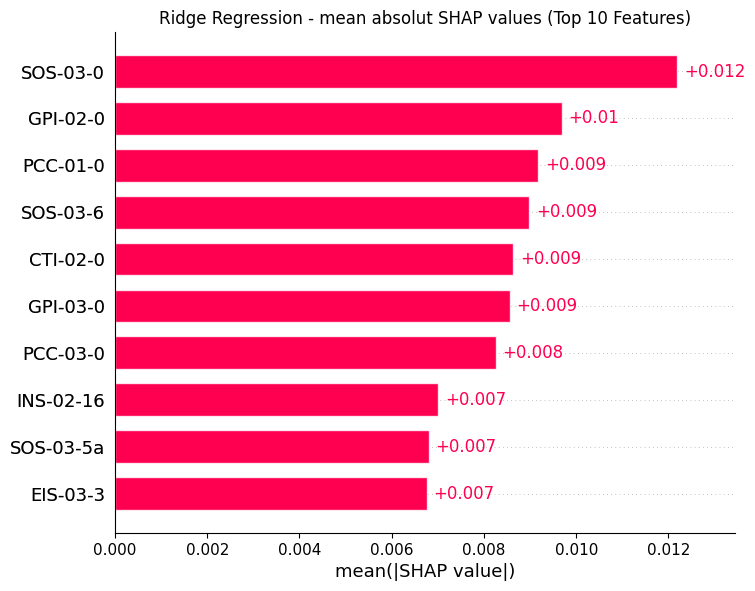

In [16]:
# Compute mean absolute SHAP values for each feature
shap_abs_mean_l2 = np.abs(shap_values_l2.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean_l2)[-10:]

# Filter SHAP values to keep only the top 10 features
shap_values_top10_l2 = shap.Explanation(
    values=shap_values_l2.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values_l2.base_values,  # Keep base values
    data=shap_values_l2.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)

# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10_l2, show=False)
plt.title("Ridge Regression - mean absolut SHAP values (Top 10 Features)")

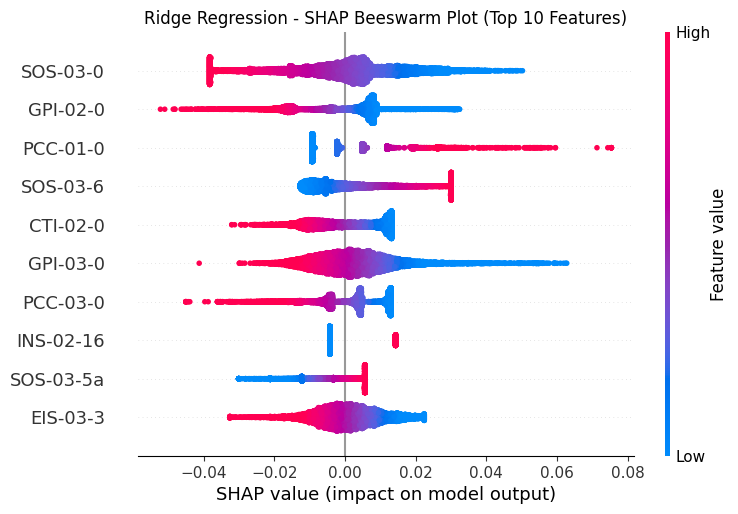

In [17]:
# Beeswarm plot for top 10 features
shap.plots.beeswarm(shap_values_top10_l2, show=False)
plt.title("Ridge Regression - SHAP Beeswarm Plot (Top 10 Features)")
plt.show()